# Chapter 3 [word2vec]
---
앞 장에서는 '통계 기반 기법'으로 단어의 분산 표현을 얻었습니다.  
이번 장에서는 '추론 기반 기법'을 살표보겠습니다.  
추론을 하는 과정에서 신경망을 이용하는데, 여기서 word2vec을 살펴보겠습니다.  
단순한 word2vec을 구현할 것이며, 처리 효율을 희생하는 대신 이해하기 쉽도록 구성하겠습니다.

## 1. 추론 기반 기법과 신경망
'통계 기반 기법'과 '추론 기반 기법'은 단어의 의미를 얻는 방식은 서로 크게 다르지만, 그 배경에는 분포 가설이 있습니다.  
이번 절에서는 통계 기반 기법의 문제를 지적하고, 그 대안인 추론 기반 기법의 이점을 설명합니다.  

### 1.1 통계 기반 기법의 문제점
이전 장에서 알아본 통계 기반 기법에서는 주변 단어의 빈도를 기초로 단어를 표현했습니다.  
정확히는 단어의 동시발생 행렬을 만들고 그 행렬에 SVD를 적용하여 밀집벡터(단어의 분산 표현)를 얻었습니다.  
그러나 이 방식은 대규모 말뭉치를 다룰 때 문제가 발생합니다.  

현업에서 다루는 말뭉치의 어휘 수는 100만을 훌쩍 넘는다고 합니다.  
어휘가 100만 개라면, 통계 기반 기법에서는 100만 x 100만의 행렬을 만들게 됩니다.  
이런 거대 행렬에 SVD를 적용하는 일은 현실적이지 않겠죠.  

---

SVD를 $n \times n$ 행렬에 적용하는 비용은 $O(n^3)$입니다.

---

통계 기반 기법은 말뭉치 전체의 통계(동시발생 행렬과 PPMI 등)를 이용해 단 1회의 처리(SVD 등)만에 단어의 분산 표현을 얻습니다.(배치 학습)  
반면 추론 기반 기법은 학습 데이터의 일부를 사용하여 순차적으로 학습합니다.(미니배치 학습)  
즉 말뭉치의 어휘 수가 많아 SVD 등 계산량이 큰 작업을 처리하기 어려운 경우에도 신경망을 학습시킬 수 있다는 뜻입니다.  
또한 여러 GPU를 이용한 병렬 계산도 가능해져서 학습 속도를 높일 수도 있습니다.  

### 1.2 추론 기반 기법 개요
<img src=img/fig3-2.png width='500'> <img src=img/fig3-3.png width='500'>
그림 3-3 처럼 추론 기반 기법에는 어떠한 모델이 등장합니다.  
모델은 맥락 정보를 입력받아 (출현할 수 있는) 각 단어의 출현 확률을 출력합니다.  
따라서 말뭉치를 사용해 모델이 올바른 추측을 내놓도록 학습시킵니다.  
그리고 그 학습결과로 단어의 분산 표현을 얻는 것이 추론 기반 기법의 전체 그림입니다.  

### 1.3 신경망에서의 단어 처리
신경망에서 단어를 처리하기 위해서 '고정 길이의 벡터'로 변환해야 합니다.  
이때 사용하는 대표적인 방법이 단어를 **원핫**<sup>one-hot</sup> **표현**(또는 **원핫 벡터**)으로 변환하는 것입니다.  
원핫 표현이란 원소중 하나면 1이고 나머지는 모두 0인 벡터를 말합니다.  
<img src=img/fig3-4.png width='500'>
그림 3-4처럼 단어는 텍스트, 단어 ID, 원핫 표현 형태로 나타낼 수 있습니다.  
단어를 고정 길이 벡터로 변환하는 신경망의 입력층은 아래의 그림처럼  뉴런 수를 고정시킬 수 있습니다.  
<img src=img/fig3-5.png width='500'>
<img src=img/fig3-6.png width='500'>
<img src=img/fig3-7.png width='500'>

## 2. 단순한 word2vec
지금부터 할 일은 그림 3-3의 '모델'을 신경망으로 구축하는 것입니다.  
그리고 이번 절에서 사용할 신경망은 word2vec에서 제안하는 **CBOW**<sup>continuous bag-of-words</sup> 모델입니다.  

### 2.1 CBOW 모델의 추론 처리
CBOW 모델은 맥락으로부터 타깃<sup>target</sup>을 추측하는 용도의 신경망입니다.('타깃'은 중앙 단어이고 그 주변 단어들이 '맥락'입니다)  
우리의 목표는 CBOW 모델이 가능한 한 정확하게 추론하도록 학습시켜서 단어의 분산 표현을 얻어낼 것입니다.  
<img src=img/fig3-9.png width='500'>
그림 3-9는 CBOW 모델의 신경망입니다.  
입력층이 2개 있고, 은닉층을 거쳐 출력층에 도달합니다.  
여기서 입력층이 2개인 이유는 맥락으로 고려할 단어를 2개(window = 1)로 정했기 때문입니다.  
즉, 맥락에 포함시킬 단어가 N개라면 입력층의 수도 N개가 됩니다.  

이처럼 입력층이 여러 개이면 은닉층도 여러 개가 생성됩니다.  
우리의 예를 대입해보면 다음과 같습니다.  
첫 번째 입력층이 $h_1$으로 변환되고, 두 번째 입력층이 $h_2$로 변환되었다고 하면, 은닉층 뉴런은 $\frac{1}{2}\left(h_1 + h_2\right)$가 되는 것이죠.  

출력층에선 뉴런 하나하나가 각각의 단어에 대응하고 있습니다. 이 출력층의 뉴런은 각 단어의 '점수'를 뜻하며, 값이 높을수록 대응 단어의 출현 확률이 높아집니다.  
여기서 점수란 확률로 해석되기 전의 값이고, 이 점수에 소프트맥스 함수를 적용해서 '확률'을 얻을 수 있습니다.  
우리는 정답 단어의 확률이 가장 높게 나오도록 신경망을 학습시킬 것입니다.  

학습이 완료되면 가중치 $W_{in}$은 맥락에서 출현하는 단어를 잘 추측하는 방향으로 변할 것입니다.  
즉 아래의 그림처럼 가중치의 각 행히 해당 단어의 분산 표현을 담고 있다고 할 수 있습니다.  
이렇게 얻은 벡터에는 '단어의 의미'도 잘 녹어들어 있습니다! 이것이 word2vec의 전체 그림입니다.
<img src=img/fig3-10.png width='400'>

### 2.2 CBOW 모델의 학습
우리가 다루고 있는 모델은 다중 클래스 분류를 수행하는 신경망입니다.  
따라서 이 신경망을 학습하려면 소프트맥스와 교차 엔트로피 오차만 이용하면 됩니다.  
소프트맥스 함수를 이용해 점수를 확률로 변환하고, 그 확률과 정답 레이블로부터 교차 엔트로피 오차를 구한 후, 그 값을 손실로 사용해 학습을 진행합니다.  

학습시 Softmax 계층과 Cross Entropy Error 계층을 사용합니다만,
우리는 이 두 개층을 Softmax with Loss라는 하나의 계층으로 구현합니다.  
따라서 우리가 앞으로 구현할 신경망의 정확한 모습은 아래 그림처럼 생겼습니다.  
<img src=img/fig3-14.png width='600'>

### 2.3 word2vec의 가중치와 분산 표현
지금까지 설명한 word2vec에서 사용되는 신경망에는 두 가지 가중치가 있습니다.  
입력 측 완전연결계층의 가중치($W_{in}$)와 출력 측 완전연결계층의 가중치($W_{out}$)입니다.  
그리고 입력 측 가중치 $W_{in}$의 각 행이 각 단어의 분산 표현에 해당합니다.  
또한 출력 측 가중치 $W_{out}$에도 단어의 의미가 인코딩된 벡터가 저장되어 있습니다.  
다만, 출력 측 가중치는 아래 그림처럼 각 단어의 분산 표현이 열 방향(수직 방향)으로 저장됩니다.  
<img src=img/fig3-15.png width='600'>
그러면 최종적으로 이용하는 단어의 분산 표현으로는 어느 쪽 가중치를 선택하면 좋을까요?  

A. 입력 측의 가중치만 이용한다.  
B. 출력 측의 가중치만 이용한다.  
C. 양쪽 가중치를 모두 이용한다.  

word2vec에서는 A 안인 '입력 층의 가중치만 이용한다'가 가장 대중적인 선택입니다.  

## 3. 학습 데이터 준비
이번에도 간단한 예로서 "You say goodbey and I say hello."라는 한 문장짜리 말뭉치를 이용합니다.  

### 3.1 맥락과 타깃
word2vec에서 이용하는 신경망의 입력은 '맥락'이고, 정답 레이블은 맥락에 둘러싸인 중앙의 단어 '타깃'입니다.  
우리가 해야 할 일은 신경망에 '맥락'을 입력했을때 '타깃'이 출현할 확률을 높이는 것입니다.  
따라서 말뭉치에서 '맥락'과 '타깃'을 아래 그림처럼 만드는 작업을 해야합니다.  
<img src=img/fig3-16.png width='600'>
그리고 이제 '맥락'과 '타깃'을 신경망에 사용할 수 있게 단어ID 배열로 만드는 작업을 진행합니다.  
말뭉치를 단어ID로 바꾸는 작업은 이전 장에서 구현한 preprocess()함수를 이용합니다.  
그런 다음 단어ID의 배열인 corpus로부터 맥락과 타깃을 만들어내는 함수를 작성하겠습니다.  
<img src=img/fig3-17.png width='600'>

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [2]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [3]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


이렇게 말뭉치로부터 맥락과 타깃을 만들어냈습니다.  
하지만 아직 한가지 처리가 남아있습니다.  
이것을 신경망 모델에 사용하려면 위에서 얻은 맥락과 타깃을 원핫 표현으로 변환해야 합니다.  

### 3.2 원핫 표현으로 변환
convert_one_hot() 함수를 구현하여 맥락과 타깃을 다음과 같이 변환해 보겠습니다.
<img src=img/fig3-18.png width='600'>

In [8]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [11]:
print(target)
print("-"*50)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


### 4. CBOW 모델 구현
이제부터 간단한 CBOW 모델을 구현하겠습니다. 우리가 구현할 신경망은 아래 그림과 같습니다.  
<img src=img/fig3-19.png width='600'>

In [12]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 244 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 245 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 246 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 247 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 248 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 249 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 250 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 251 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 252 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 253 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 254 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 255 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 256 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 257 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 258 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 259 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 260 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 261 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 262 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 263 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 264 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 265 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 266 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 267 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 268 |  반복 1

| 에폭 508 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 509 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 510 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 511 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 512 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 513 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 514 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 515 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 516 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 517 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 518 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 519 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 520 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 521 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 522 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 523 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 524 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 525 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 526 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 527 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 528 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 529 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 530 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 531 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 532 |  반복 1

| 에폭 771 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 772 |  반복 1 / 2 | 시간 0[s] | 손실 0.38
| 에폭 773 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 774 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 775 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 776 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 777 |  반복 1 / 2 | 시간 0[s] | 손실 0.38
| 에폭 778 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 779 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 780 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 781 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 782 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 783 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 784 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 785 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 786 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 787 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 788 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 789 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 790 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 791 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 792 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 793 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 794 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 795 |  반복 1

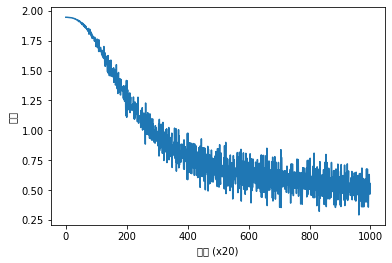

you [-0.970163  -1.3220888 -1.306336  -0.9477208 -1.2814251]
say [1.3858694  0.33748078 0.14837533 1.3667399  0.19945174]
goodbye [-1.1368446  -0.41977242 -0.48415658 -1.1612915  -0.5256851 ]
and [ 1.2519841 -1.4976282 -1.4472945  1.2249179 -1.4541185]
i [-1.1316916  -0.42108947 -0.482437   -1.1636345  -0.5317376 ]
hello [-0.9740932 -1.3347901 -1.3158157 -0.9407425 -1.2742372]
. [1.0656348 1.2745954 1.271898  1.0612358 1.280366 ]


In [16]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

마침내 단어를 밀집벡터로 나타낼 수 있게 되었습니다.  
이 밀집벡터가 바로 단어의 분산 표현입니다.  

하지만 여기서 다룬 말뭉치는 너무 작아서 좋은 결과를 얻을 수 없습니다.
충분히 큰 말뭉치로 바꾸면 결과도 좋아지겠지만, 처리 속도 면에서 문제가 생깁니다.  
지금 구현한 CBOW 모델은 처리 효율 면에서 몇 가지 문제가 있습니다.  
그래서 다음 장에서 '단순한' CBOW 모델을 개선하여 '진짜' CBOW 모델을 구현하겠습니다.  

## 5. 통계 기반 vs. 추론 기반
통계 기반 기법은 말뭉치의 전체 통계로부터 1회 학습하여 단어의 분산 표현을 얻었습니다.  
추론 기반 기법은 말뭉치를 일부분씩 여러 번 보면서 학습했습니다.  
이번 절에서는 이 학습 방법 외에 두 기법이 또 어떻게 다른지 비교해보겠습니다.  

먼저, 어휘에 추가할 새 단어가 생겨서 단어의 분산 표현을 갱신해야 하는 상황을 생각해봅시다.  
통계 기반 기법에서는 계산을 처음부터 다시 해야 합니다.
반면 추론 기반 기법은 매개변수를 다시 학습할 수 있습니다.  
지금까지 학습한 가중치를 초깃값으로 사용해 다시 학습하면 되는데, 이런 특성 덕분에 기존에 학습한 경험을 해치지 않으면서 단어의 분산 표현을 해치지 않으면서 단어의 분산 표현을 효율적으로 갱신할 수 있습니다.  
이 점에서는 확실히 추론 기반 기법이 우세합니다.

다음으로 두 기법으로 얻는 단어의 분산 표현의 성격이나 정밀도 면은 어떨까요?  
통계 기반 기법에서는 주로 단어의 유사성이 인코딩됩니다.  
한편 word2vec에서는 단어의 유사성은 물론, 한층 복잡한 단어 사이의 패턴까지도 파악되어 인코딩됩니다.  
word2vec은 "king - man + woman = queen"과 같은 유추 문제를 풀 수 있다는 이야기로 유명한데, 바로 이 특성을 방증하는 예입니다.  

이런 이유로 추론 기반 기법이 통계 기반 기법보다 정확하다고 생각할 수 있는데, 실제로 단어의 유사성을 정량 평가해본 결과, 의외로 두 기법의 우열을 가릴 수 없었다고 합니다.  